In [128]:
%pip install tqdm catboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import random
import pickle
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import shap
import spacy
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer, util
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [2]:
# Load models once for efficiency
bert_model = SentenceTransformer("paraphrase-MiniLM-L3-v2")  # Lighter SBERT model
ai_tokenizer = AutoTokenizer.from_pretrained("roberta-base-openai-detector")
ai_model = AutoModelForSequenceClassification.from_pretrained("roberta-base-openai-detector")

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Clean Text

In [131]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text) 
    text = text.lower().strip() 
    return text

### Entropy Calculation

In [132]:
def calculate_entropy(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0  # Return low entropy for empty text
    vectorizer = CountVectorizer()
    try:
        X = vectorizer.fit_transform([text])
    except ValueError:  # Catch empty vocabulary error
        return 0  
    probs = np.array(X.toarray()[0], dtype=np.float32)
    if np.sum(probs) == 0:
        return 0  # Avoid division by zero
    probs = probs / np.sum(probs)
    entropy = -np.sum(probs * np.log2(probs))
    return entropy

### Check Relevance (batched)

In [133]:
def check_relevance_batch(responses, expected_context, bert_model):
    # Convert single expected_context into an embedding (only once for efficiency)
    context_embedding = bert_model.encode(expected_context, convert_to_tensor=True)
    
    # Encode all responses in a batch
    response_embeddings = bert_model.encode(responses, convert_to_tensor=True)
    
    # Compute cosine similarities in one operation
    similarities = util.pytorch_cos_sim(response_embeddings, context_embedding).cpu().numpy()

    return similarities #> 0.25  # Returns a NumPy array of similarity scores


### Detect AI-generated Content

In [134]:
def detect_ai_generated(text, ai_tokenizer, ai_model):
    if not isinstance(text, str) or text.strip() == "":
        return False

    inputs = ai_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    with torch.no_grad():
        outputs = ai_model(**inputs)

    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    ai_probability = probabilities[0][1].item()  # Assuming 1 is the AI-generated class

    return ai_probability #> 0.5  # Adjust this threshold as needed



# CATBOOST

In [135]:
from catboost import CatBoostClassifier

### Load and Process Data

In [136]:
def process_df(sheet_name,training_path="Final Data File_Training.xlsx"):
    df = pd.read_excel(training_path,sheet_name=sheet_name)
    d = {}
    cols = df.columns
    
    for i in range(len(cols)):
        if cols[i].startswith("Unnamed"): 
            d[cols[i]] = df.iloc[0, i]  
    df = df.rename(columns = d)
    df.drop([0],axis=0,inplace=True)
    d = {}
    for i in range(len(cols)):
        if cols[i].startswith("Q"): 
            d[cols[i]] = cols[i][0:cols[i].index(' ')]
    df = df.rename(columns=d)
    df = df.fillna("")
    df['time_taken'] = (df['End Date'] - df['Start Date']).dt.total_seconds()
    df.insert(3, 'time_taken', df.pop('time_taken'))
    return df

### Helper Function to Generate Features

In [137]:
def generate_features(df, column_names, column_groups, feature_types=["mean", "var", "interaction",'ratio']):
    new_features = pd.DataFrame(index=df.index)  # Keep index aligned with original DF
    
    group_name = '_'.join(column_names)
    if "mean" in feature_types:
        new_features[f"{group_name}_Mean"] = df[column_groups].mean(axis=1)
    
    if "var" in feature_types:
        new_features[f"{group_name}_Var"] = df[column_groups].var(axis=1)
    
    if "interaction" in feature_types:
        col1 = column_groups[0]
        col2 = column_groups[1]
        new_features[f"{col1}_x_{col2}"] = df[col1] * df[col2]
    if "ratio" in feature_types:
        col1 = column_groups[0]
        col2 = column_groups[1]
        new_features[f"{col1}_/_{col2}"] = df[col1] / df[col2]

    return new_features

### Apply Feature Engineering

In [138]:
def apply_feature_engg(df, column_names, feature_types):
    cmp = {'Q1.':'Age','Q2.':'Gender','Q3.':'Urban/Rural','Q4.':'Income','Q9.':'Relevance','Q10.':'Appeal','Q11.':'Differentiation','Q12.':'Believability','Q13.':'Price','Q14.':'Purchase_Intent','Q15.':'Drinking_Frequency'}
    cmp = {v: k for k, v in cmp.items()}
    print(column_names)
    res_df = generate_features(df, column_names, [cmp[i] for i in column_names], feature_types)
    return pd.concat([df,res_df], axis=1)
    

### Binary Encode Categorical Columns

In [139]:
def binary_encode_dataframe(df, categorical_cols):
    binary_encoded_dfs = []
    
    for col in categorical_cols:
        unique_vals = df[col].unique()
        mapping = {val: idx for idx, val in enumerate(unique_vals)}  # Label Encoding
        max_bits = len(bin(len(mapping) - 1)[2:])  # Find required bits

        binary_encoded = df[col].map(mapping).apply(lambda x: list(map(int, bin(x)[2:].zfill(max_bits))))
        binary_df = pd.DataFrame(binary_encoded.tolist(), columns=[f"{col}bin{i}" for i in range(max_bits)], index=df.index)
        binary_encoded_dfs.append(binary_df)

    # Concatenate the binary-encoded features with the original numerical features
    df_encoded = pd.concat([df.drop(columns=categorical_cols)] + binary_encoded_dfs, axis=1)
    
    return df_encoded

### Detect Copy Pasted Content (across responses of a single person)

In [140]:
def detect_copy_paste(df, bert_model):
    similarity_results = []
    
    # Get all text columns dynamically
    text_columns = ['Q16A.','Q16B.'] # df.select_dtypes(include=['object']).columns.tolist() 
    
    for idx, row in df.iterrows():
        try:
            # Get responses for text columns only
            responses = row[text_columns].astype(str).tolist()
            
            # Encode responses using pre-trained BERT model
            embeddings = bert_model.encode(responses, convert_to_tensor=True)
            
            # Compute cosine similarities
            cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
            
            # Get upper triangle values (excluding diagonal)
            n = len(responses)
            upper_triangle_values = [cosine_scores[i][j].item() 
                                   for i in range(n) for j in range(i+1, n)]
            
        except Exception as e:
            print(f"Error processing responder {idx}: {str(e)}")
            upper_triangle_values = [0.0] * (len(text_columns) * (len(text_columns)-1)) // 2
            
        similarity_results.append(upper_triangle_values)
    
    # Generate column names for pairs of text questions
    question_pairs = [f"sim_{text_columns[i]}_{text_columns[j]}" 
                     for i in range(len(text_columns)) for j in range(i+1, len(text_columns))]
    
    return pd.DataFrame(similarity_results, columns=question_pairs, index=df.index)

#scalable code

### Apply Processing to Sheet 1

In [141]:
df = process_df(1)
df.head()

/var/folders/sl/kmcbrl6d3m72vgm_37_mw72w0000gn/T/ipykernel_20851/3893371241.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna("")


,Unique ID,Start Date,End Date,time_taken,Q1.,Q2.,Q3.,Q4.,Q6,Flavored/Mixed Beer,...,Q13.,Q14.,Q15.,Q16A.,Q16B.,Q17.,Q18_1,Q18_2,Q18_3,OE_Quality_Flag
1,3.0,2024-10-11 09:43:37,2024-10-11 09:53:40,603.0,60.0,2.0,3.0,12.0,1,0,...,3.0,2.0,2.0,the packaging,nothing,1.0,,,,0.0
2,5.0,2024-10-11 09:42:41,2024-10-11 09:55:49,788.0,61.0,1.0,3.0,3.0,1,0,...,3.0,5.0,4.0,It's a good and trusted brand.,It's seem some what generic.,2.0,Heineken,Miller Lite,Budwieser,0.0
3,6.0,2024-10-11 09:46:20,2024-10-11 09:56:42,622.0,58.0,1.0,1.0,8.0,1,0,...,3.0,1.0,0.0,Just that it is a lager beer,I don't like Anheiser Busch and their values a...,1.0,,,,0.0
4,8.0,2024-10-11 09:47:15,2024-10-11 09:57:19,604.0,55.0,1.0,3.0,11.0,1,0,...,3.0,5.0,7.0,has a less filling effect,no dislike,2.0,michelob ultra,Miller light,corona,0.0
5,10.0,2024-10-11 09:45:24,2024-10-11 09:57:30,726.0,64.0,1.0,5.0,3.0,1,1,...,5.0,5.0,6.0,Everything,Nothing,3.0,Coors light,Bud,Coors,0.0


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 1 to 2299
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unique ID              2299 non-null   float64       
 1   Start Date             2299 non-null   datetime64[ns]
 2   End Date               2299 non-null   datetime64[ns]
 3   time_taken             2299 non-null   float64       
 4   Q1.                    2299 non-null   float64       
 5   Q2.                    2299 non-null   float64       
 6   Q3.                    2299 non-null   float64       
 7   Q4.                    2299 non-null   float64       
 8   Q6                     2299 non-null   int64         
 9    Flavored/Mixed Beer   2299 non-null   int64         
 10   Non-Alcoholic Beers   2299 non-null   int64         
 11   Hard Ciders           2299 non-null   int64         
 12   Hard Kombucha         2299 non-null   int64         
 13   Wi

### Apply Feature Engineering to Loaded Data

In [143]:
df = apply_feature_engg(df, ['Relevance','Appeal','Differentiation','Believability'],['mean','var'])
df = apply_feature_engg(df, ['Price','Purchase_Intent'],['mean','interaction'])
df = apply_feature_engg(df, ['Drinking_Frequency','Purchase_Intent'],['mean','var'])
df = apply_feature_engg(df, ['Income','Price'],['mean','var'])
df.head()

['Relevance', 'Appeal', 'Differentiation', 'Believability']
['Price', 'Purchase_Intent']
['Drinking_Frequency', 'Purchase_Intent']
['Income', 'Price']


,Unique ID,Start Date,End Date,time_taken,Q1.,Q2.,Q3.,Q4.,Q6,Flavored/Mixed Beer,...,Q18_3,OE_Quality_Flag,Relevance_Appeal_Differentiation_Believability_Mean,Relevance_Appeal_Differentiation_Believability_Var,Price_Purchase_Intent_Mean,Q13._x_Q14.,Drinking_Frequency_Purchase_Intent_Mean,Drinking_Frequency_Purchase_Intent_Var,Income_Price_Mean,Income_Price_Var
1,3.0,2024-10-11 09:43:37,2024-10-11 09:53:40,603.0,60.0,2.0,3.0,12.0,1,0,...,,0.0,2.75,0.250000,2.5,6.0,2.0,0.0,7.5,40.5
2,5.0,2024-10-11 09:42:41,2024-10-11 09:55:49,788.0,61.0,1.0,3.0,3.0,1,0,...,Budwieser,0.0,4.50,0.333333,4.0,15.0,4.5,0.5,3.0,0.0
3,6.0,2024-10-11 09:46:20,2024-10-11 09:56:42,622.0,58.0,1.0,1.0,8.0,1,0,...,,0.0,3.00,0.666667,2.0,3.0,0.5,0.5,5.5,12.5
4,8.0,2024-10-11 09:47:15,2024-10-11 09:57:19,604.0,55.0,1.0,3.0,11.0,1,0,...,corona,0.0,3.75,0.250000,4.0,15.0,6.0,2.0,7.0,32.0
5,10.0,2024-10-11 09:45:24,2024-10-11 09:57:30,726.0,64.0,1.0,5.0,3.0,1,1,...,Coors,0.0,4.75,0.250000,5.0,25.0,5.5,0.5,4.0,2.0


### Clean text columns and Calculate Entropy (for Gibberish Detection)

In [144]:
df['Q16A.'] = df['Q16A.'].apply(lambda x: clean_text(x))
df['Q16B.'] = df['Q16B.'].apply(lambda x: clean_text(x))

df['gibberish_16A'] = df['Q16A.'].apply(lambda x: calculate_entropy(x))
df['gibberish_16B'] = df['Q16B.'].apply(lambda x: calculate_entropy(x))

### Detect AI Generated Content from Responses

In [147]:
from tqdm.auto import tqdm
tqdm.pandas()
df['ai_generated_16A'] = df['Q16A.'].progress_apply(lambda x: detect_ai_generated(x, ai_tokenizer, ai_model))
df['ai_generated_16B'] = df['Q16B.'].progress_apply(lambda x: detect_ai_generated(x, ai_tokenizer, ai_model))

  0%|          | 0/2299 [00:00<?, ?it/s]

  0%|          | 0/2299 [00:00<?, ?it/s]

In [148]:
# dft['ai_generated_16A'] = dft['ai_generated_16A'].astype('float')
# dft['ai_generated_16B'] = dft['ai_generated_16B'].astype('float')

### Check Relevance of Responses to Open Ended Questions

In [149]:
q16a_question = "What is the most important thing you LIKE about the shown concept? This can include anything you would want kept for sure or aspects that might drive you to buy or try it."
q16b_question = "What is the most important thing you DISLIKE about the shown concept? This can include general concerns, annoyances, or any aspects of the product that need fixing for this to be more appealing to you."

df["is_relevant_16A"] = check_relevance_batch(df["Q16A."].tolist(), q16a_question, bert_model)
df["is_relevant_16B"] = check_relevance_batch(df["Q16B."].tolist(), q16b_question, bert_model)

### Detect Copy Pasted Content from Open Ended Responses

In [150]:
resdf = detect_copy_paste(df[['Q16A.', 'Q16B.']], bert_model)
df = pd.concat([df,resdf], axis = 1)

### Prepare columns for Conversion

In [151]:
cols_to_convert = []
for i in df.columns[:29]:
    if df[i].dtype == "object":
        cols_to_convert.append(i)
cols_to_convert

[]

### Prepare to drop Open Ended columns (no longer required)

In [152]:
cols_to_drop = []
for i in df.columns[30:36]:
    if df[i].dtype == "object":
        cols_to_drop.append(i)
cols_to_drop

['Q16A.', 'Q16B.', 'Q18_1', 'Q18_2', 'Q18_3']

### Drop Unnecessary columns

In [153]:
df = df.fillna('')
dft = df.drop(cols_to_drop+['Start Date', 'End Date', 'Unique ID','time_taken'], axis=1, inplace=False)
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 1 to 2299
Data columns (total 43 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Q1.                                                  2299 non-null   float64
 1   Q2.                                                  2299 non-null   float64
 2   Q3.                                                  2299 non-null   float64
 3   Q4.                                                  2299 non-null   float64
 4   Q6                                                   2299 non-null   int64  
 5    Flavored/Mixed Beer                                 2299 non-null   int64  
 6    Non-Alcoholic Beers                                 2299 non-null   int64  
 7    Hard Ciders                                         2299 non-null   int64  
 8    Hard Kombucha                                       2299 non-null  

### Use other Sheet for Keeping Categorical columns, Binary Encode first DataFrame

In [154]:
dftt = process_df(0)
cols_to_binarize=[]
cols_to_binarize.extend(['Q2.','Q3.','Q4.'])
for i in range(9,16):
    col = 'Q'+str(i)+'.'
    cols_to_binarize.append(col)   
cols_to_binarize.append('Q17.')
for i in cols_to_binarize:
    dft[i] = dftt[i]
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 1 to 2299
Data columns (total 43 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Q1.                                                  2299 non-null   float64
 1   Q2.                                                  2299 non-null   object 
 2   Q3.                                                  2299 non-null   object 
 3   Q4.                                                  2299 non-null   object 
 4   Q6                                                   2299 non-null   int64  
 5    Flavored/Mixed Beer                                 2299 non-null   int64  
 6    Non-Alcoholic Beers                                 2299 non-null   int64  
 7    Hard Ciders                                         2299 non-null   int64  
 8    Hard Kombucha                                       2299 non-null  

In [155]:
dft = binary_encode_dataframe(dft,cols_to_binarize)

In [156]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 1 to 2299
Data columns (total 65 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Q1.                                                  2299 non-null   float64
 1   Q6                                                   2299 non-null   int64  
 2    Flavored/Mixed Beer                                 2299 non-null   int64  
 3    Non-Alcoholic Beers                                 2299 non-null   int64  
 4    Hard Ciders                                         2299 non-null   int64  
 5    Hard Kombucha                                       2299 non-null   int64  
 6    Wine                                                2299 non-null   int64  
 7    Hard Beverage                                       2299 non-null   int64  
 8    Distilled Spirits                                   2299 non-null  

In [157]:
dft['ai_generated_16A'] = dft['ai_generated_16A'].astype('float')
dft['ai_generated_16B'] = dft['ai_generated_16B'].astype('float')

### Prepare Features for CatBoost

In [158]:
cat_features = []
for i in dft.columns:
    if dft[i].dtype=='object':
        cat_features.append(i)
cat_features

[]

In [159]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 1 to 2299
Data columns (total 65 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Q1.                                                  2299 non-null   float64
 1   Q6                                                   2299 non-null   int64  
 2    Flavored/Mixed Beer                                 2299 non-null   int64  
 3    Non-Alcoholic Beers                                 2299 non-null   int64  
 4    Hard Ciders                                         2299 non-null   int64  
 5    Hard Kombucha                                       2299 non-null   int64  
 6    Wine                                                2299 non-null   int64  
 7    Hard Beverage                                       2299 non-null   int64  
 8    Distilled Spirits                                   2299 non-null  

### Fit CatBoost Model After Splitting Data

In [160]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    dft.drop(columns=["OE_Quality_Flag"]), dft["OE_Quality_Flag"], test_size=0.2, random_state=42, stratify=dft["OE_Quality_Flag"]
)
scale_pos_weight = dft['OE_Quality_Flag'].value_counts()[0] / dft['OE_Quality_Flag'].value_counts()[1]
# Initialize and train CatBoost model
model = CatBoostClassifier(iterations=100, depth=8, learning_rate=0.008, cat_features=cat_features, scale_pos_weight=scale_pos_weight, verbose=0, l2_leaf_reg=7)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)

### Make Predictions and Visualize Confusion Matrix

In [161]:
# Predict on test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy: 0.83
Confusion Matrix:
[[378  46]
 [ 31   5]]


### Save the CatBoost Model

In [162]:
model.save_model('catboost_model.cbm')

### Experiments on CatBoost Predicted Probability

In [163]:
# Convert y_test to NumPy array for correct indexing
y_test_array = y_test.to_numpy()

# Get prediction probabilities
pred_probs = model.predict_proba(X_test)
res = []
# Iterate through predictions safely
for i in range(len(y_test_array)):
    #if y_test_array[i]:  # ✅ Now indexing is safe
    res.append(1 if pred_probs[i][1]>0.49 else 0)
    #else:
        #res.append(res.append(1 if pred_probs[i][0]>0.49 else 0))
res = np.array(res)
cm = confusion_matrix(y_test, res)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[346  78]
 [ 24  12]]


### Save CatBoost Model as Pickle file

In [164]:
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Calculating Metrics from Confusion Matrix

In [165]:
print('precision: ',(cm[1][1]/(cm[0][1] + cm[1][1])))
print('recall: ',(cm[1][1]/(cm[1][0] + cm[1][1])))

precision:  0.13333333333333333
recall:  0.3333333333333333


### Get Feature Importance from CatBoost Model

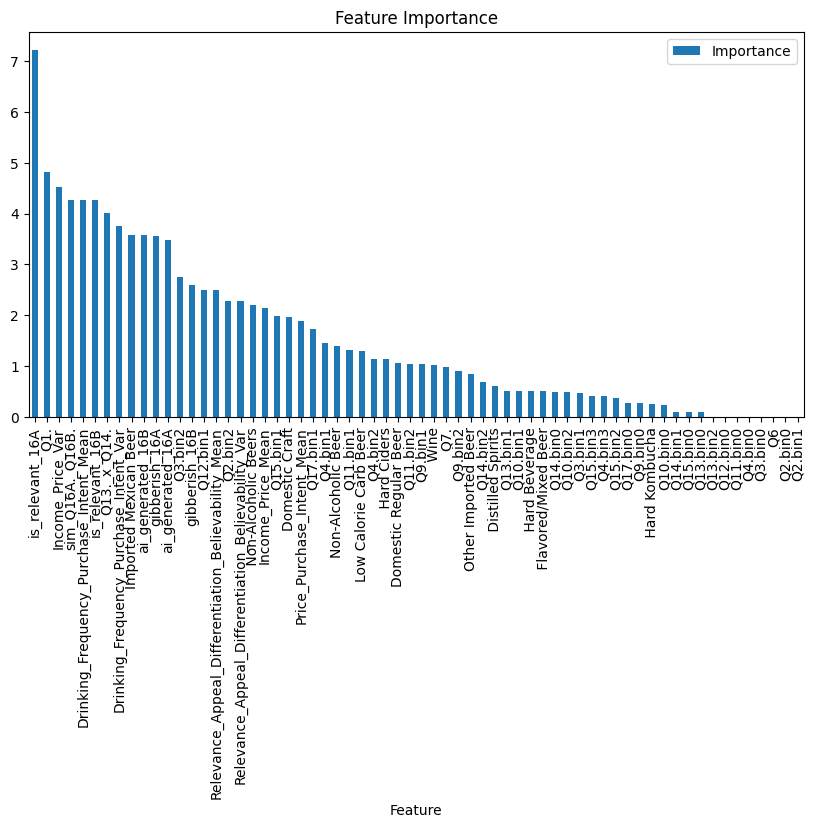

In [166]:
# Get feature importance
feature_importance = model.get_feature_importance()
feature_names = model.feature_names_

# Convert to DataFrame
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})

# Sort and plot
importance_df.sort_values(by="Importance", ascending=False).plot(kind="bar", x="Feature", y="Importance", figsize=(10, 5), title="Feature Importance")
plt.show()

### Use SHAP for visualizing Feature Impact on Model Predictions

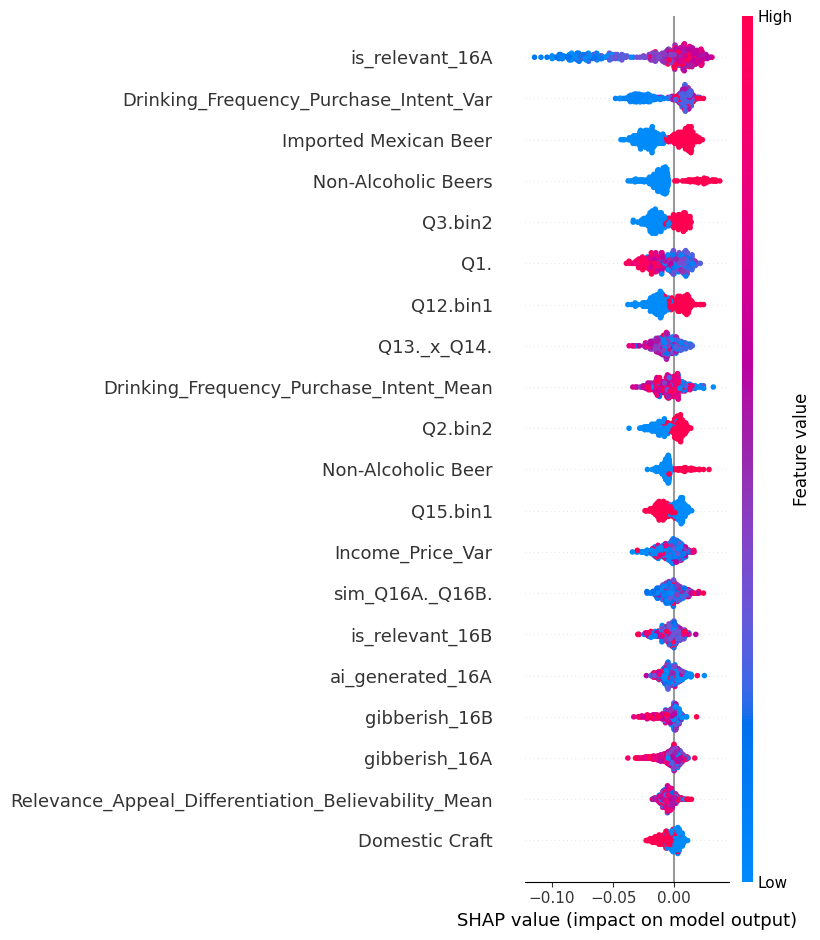

In [167]:
# Initialize SHAP explainer for CatBoost
explainer = shap.TreeExplainer(model)

# Get SHAP values
shap_values = explainer.shap_values(X_test)

# ✅ Now you can visualize!
shap.summary_plot(shap_values, X_test)

# XGBOOST

### Training and Testing XGBoost Model

In [168]:
for i in cols_to_convert:
    dft[i] = dft[i].astype('int')
X = dft.drop(['OE_Quality_Flag'], axis=1, inplace=False)
y = dft['OE_Quality_Flag']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
scale_pos_weight = dft['OE_Quality_Flag'].value_counts()[0] / dft['OE_Quality_Flag'].value_counts()[1]
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight,eval_metric="aucpr")
model.fit(X_train, y_train)

# Accuracy score
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.908695652173913


### Visualizing Confusion Matrix

In [169]:
# Predictions
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[418   6]
 [ 36   0]]


In [170]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 1 to 2299
Data columns (total 65 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Q1.                                                  2299 non-null   float64
 1   Q6                                                   2299 non-null   int64  
 2    Flavored/Mixed Beer                                 2299 non-null   int64  
 3    Non-Alcoholic Beers                                 2299 non-null   int64  
 4    Hard Ciders                                         2299 non-null   int64  
 5    Hard Kombucha                                       2299 non-null   int64  
 6    Wine                                                2299 non-null   int64  
 7    Hard Beverage                                       2299 non-null   int64  
 8    Distilled Spirits                                   2299 non-null  

# One class svm

### Training and Testing One Class SVMs on both Target Classes Separately

In [171]:
y = dft['OE_Quality_Flag']
scaler = StandardScaler()
# Split into train and test
train_df, test_df = train_test_split(dft, test_size=0.2, random_state=42, stratify=y)

X_train_0 = train_df[train_df['OE_Quality_Flag'] == 0].drop(columns=['OE_Quality_Flag'])
print(X_train_0.info())
X_train_1 = train_df[train_df['OE_Quality_Flag'] == 1].drop(columns=['OE_Quality_Flag'])
print(X_train_1.info())

X_test = test_df.drop(columns=['OE_Quality_Flag'])
y_test = test_df['OE_Quality_Flag']

# Train One-Class SVMs separately
svm_0 = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale').fit(X_train_0)
svm_1 = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale').fit(X_train_1)

# Get decision function scores for test data
score_0 = svm_0.decision_function(X_test)
score_1 = svm_1.decision_function(X_test)

# Predict class based on which model gives a higher confidence score
y_pred0 = np.where(score_0 > 0.5, 0, 1)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred0)

print("Confusion Matrix:")
print(cm)

y_pred1 = np.where(score_1 > 0.5, 1, 0)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred1)

print("Confusion Matrix:")
print(cm)

<class 'pandas.core.frame.DataFrame'>
Index: 1695 entries, 156 to 131
Data columns (total 64 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Q1.                                                  1695 non-null   float64
 1   Q6                                                   1695 non-null   int64  
 2    Flavored/Mixed Beer                                 1695 non-null   int64  
 3    Non-Alcoholic Beers                                 1695 non-null   int64  
 4    Hard Ciders                                         1695 non-null   int64  
 5    Hard Kombucha                                       1695 non-null   int64  
 6    Wine                                                1695 non-null   int64  
 7    Hard Beverage                                       1695 non-null   int64  
 8    Distilled Spirits                                   1695 non-null   int

### Experiment with StandardScaler

In [172]:
# Load dataset (assuming `dft` is your dataset)
y = dft['OE_Quality_Flag']

# Split into training and testing sets (80% train, 20% test)
train_df, test_df = train_test_split(dft, test_size=0.2, random_state=42, stratify=y)

# Extract target variable before scaling
y_train = train_df['OE_Quality_Flag']
y_test = test_df['OE_Quality_Flag']

# Drop target before applying scaler
X_train = train_df.drop(columns=['OE_Quality_Flag'])
X_test = test_df.drop(columns=['OE_Quality_Flag'])

# ✅ Apply StandardScaler correctly
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  # Fit on training set, transform training set
X_test_scaled = scaler.transform(X_test)  # Transform test set (DO NOT fit again!)

# Convert back to DataFrame (to preserve column names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Add target variable back
train_df = X_train_scaled.copy()
train_df['OE_Quality_Flag'] = y_train

test_df = X_test_scaled.copy()
test_df['OE_Quality_Flag'] = y_test

# ✅ Train One-Class SVMs separately for each class
X_train_0 = train_df[train_df['OE_Quality_Flag'] == 0].drop(columns=['OE_Quality_Flag'])
X_train_1 = train_df[train_df['OE_Quality_Flag'] == 1].drop(columns=['OE_Quality_Flag'])

svm_0 = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale').fit(X_train_0)
svm_1 = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale').fit(X_train_1)

# ✅ Get decision function scores for test data
X_test = test_df.drop(columns=['OE_Quality_Flag'])
score_0 = svm_0.decision_function(X_test)
score_1 = svm_1.decision_function(X_test)

# ✅ Predict class based on which model gives a higher confidence score
y_pred0 = np.where(score_0 > 0.5, 0, 1)
y_pred1 = np.where(score_1 > 0.5, 1, 0)

# ✅ Compute confusion matrices
cm_0 = confusion_matrix(y_test, y_pred0)
cm_1 = confusion_matrix(y_test, y_pred1)

print("Confusion Matrix (SVM trained on class 0):")
print(cm_0)

print("\nConfusion Matrix (SVM trained on class 1):")
print(cm_1)


Confusion Matrix (SVM trained on class 0):
[[360  64]
 [ 29   7]]

Confusion Matrix (SVM trained on class 1):
[[424   0]
 [ 36   0]]


In [173]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 1 to 2299
Data columns (total 65 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Q1.                                                  2299 non-null   float64
 1   Q6                                                   2299 non-null   int64  
 2    Flavored/Mixed Beer                                 2299 non-null   int64  
 3    Non-Alcoholic Beers                                 2299 non-null   int64  
 4    Hard Ciders                                         2299 non-null   int64  
 5    Hard Kombucha                                       2299 non-null   int64  
 6    Wine                                                2299 non-null   int64  
 7    Hard Beverage                                       2299 non-null   int64  
 8    Distilled Spirits                                   2299 non-null  

## Prototypical Network (Neural Network based Few Shot Learning Method)

### Preparing data for the Model

In [174]:
y = dft['OE_Quality_Flag']

# Split into training and testing sets (80% train, 20% test)
train_df, test_df = train_test_split(dft, test_size=0.2, random_state=42, stratify=y)

# Extract target variable before scaling
y_train = train_df['OE_Quality_Flag']
y_test = test_df['OE_Quality_Flag']

# Drop target before applying scaler
X_train = train_df.drop(columns=['OE_Quality_Flag'])
X_test = test_df.drop(columns=['OE_Quality_Flag'])

# ✅ Apply StandardScaler correctly
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  # Fit on training set, transform training set
X_test_scaled = scaler.transform(X_test)  # Transform test set (DO NOT fit again!)

# Convert back to DataFrame (to preserve column names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Add target variable back
train_df = X_train_scaled.copy()
train_df['OE_Quality_Flag'] = y_train

test_df = X_test_scaled.copy()
test_df['OE_Quality_Flag'] = y_test

### Defining Dataset and Dataloader

In [175]:
cols = list(dft.columns)
cols.remove('OE_Quality_Flag')
scaler = StandardScaler()
dft[cols] = scaler.fit_transform(dft[cols])

class EpisodicTabularDataset(Dataset):
    def __init__(self, dataframe, num_episodes=1000, support_size=5, query_size=5):
        self.num_episodes = num_episodes
        self.support_size = support_size
        self.query_size = query_size
        
        # Split data by class
        self.class_0 = dataframe[dataframe['OE_Quality_Flag'] == 0]
        self.class_1 = dataframe[dataframe['OE_Quality_Flag'] == 1]

        # Convert to tensors
        self.class_0_X = torch.tensor(self.class_0.drop(columns=['OE_Quality_Flag']).values, dtype=torch.float32)
        self.class_1_X = torch.tensor(self.class_1.drop(columns=['OE_Quality_Flag']).values, dtype=torch.float32)
        self.class_0_y = torch.zeros(len(self.class_0), 1)  # Class 0 labels
        self.class_1_y = torch.ones(len(self.class_1), 1)   # Class 1 labels

    def __len__(self):
        return self.num_episodes

    def __getitem__(self, idx):
        """
        Returns a single episode: (support_X, support_y, query_X, query_y)
        """
        support_X, support_y, query_X, query_y = [], [], [], []

        for class_X, class_y in [(self.class_0_X, self.class_0_y), (self.class_1_X, self.class_1_y)]:
            indices = random.sample(range(len(class_X)), self.support_size + self.query_size)
            support_indices = indices[:self.support_size]
            query_indices = indices[self.support_size:]

            support_X.append(class_X[support_indices])
            support_y.append(class_y[support_indices])
            query_X.append(class_X[query_indices])
            query_y.append(class_y[query_indices])

        # Stack tensors for batch processing
        support_X = torch.cat(support_X, dim=0)
        support_y = torch.cat(support_y, dim=0)
        query_X = torch.cat(query_X, dim=0)
        query_y = torch.cat(query_y, dim=0)

        return support_X, support_y, query_X, query_y



episodic_dataset = EpisodicTabularDataset(dft, num_episodes=100, support_size=5, query_size=5)
dataloader = DataLoader(episodic_dataset, batch_size=1, shuffle=True)  # 1 episode per batch

# 3️⃣ Example of Loading an Episode
for support_X, support_y, query_X, query_y in dataloader:
    print("Support Set X:", support_X.shape)  # [10, num_features]
    print("Support Set y:", support_y.shape)  # [10, 1]
    print("Query Set X:", query_X.shape)      # [10, num_features]
    print("Query Set y:", query_y.shape)      # [10, 1]
    break  # Only show first batch

Support Set X: torch.Size([1, 10, 64])
Support Set y: torch.Size([1, 10, 1])
Query Set X: torch.Size([1, 10, 64])
Query Set y: torch.Size([1, 10, 1])


### Defining the Model (Protoypical Network)

In [ ]:
import torch
import torch.nn as nn

class ProtoNet(nn.Module):
    def __init__(self, input_dim):
        super(ProtoNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(64, 32)  # Smaller embedding
        )
        # Register prototypes as a buffer
        self.register_buffer("prototypes", torch.zeros(2,32))  

    def forward(self, x):
        return self.fc(x)

    def compute_and_store_prototypes(self, support_X, support_y):
        """
        Computes class prototypes and stores them in the model as a buffer.
        """
        with torch.no_grad():
            embeddings = self(support_X)  # Get embeddings

            unique_classes = torch.unique(support_y)
            prototypes = torch.stack([
                embeddings[support_y.squeeze(-1) == c].mean(dim=0) for c in unique_classes
            ])

        self.prototypes = prototypes  # Store prototypes inside the buffer

    def get_prototypes(self):
        """
        Returns stored prototypes.
        """
        if self.prototypes.numel() == 0:
            raise ValueError("Prototypes have not been computed. Call compute_and_store_prototypes() first.")
        return self.prototypes

### Functions to Compute Class Prototypes and Loss

In [177]:
def compute_prototypes(support_X, support_y, model):
    with torch.no_grad():
        embeddings = model(support_X)  # Get embeddings
    unique_classes = torch.unique(support_y)
    prototypes = torch.stack([embeddings[support_y.squeeze() == c].mean(0) for c in unique_classes])
    return prototypes

def compute_loss(prototypes, query_X, query_y, model):
    query_embeddings = model(query_X)  # Get query embeddings
    distances = torch.cdist(query_embeddings, prototypes)  # Euclidean distance
    log_probs = F.log_softmax(-distances, dim=1)  # Convert distances to log probs
    if query_y == None:
        return None, log_probs
    loss = F.nll_loss(log_probs, query_y.squeeze().long())  # Negative Log-Likelihood Loss
    return loss, log_probs

### Training and Evaluation Functions

In [190]:
def train_protonet(model, dataloader, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for support_X, support_y, query_X, query_y in dataloader:
            optimizer.zero_grad()

            # Compute and store prototypes inside the model
            model.compute_and_store_prototypes(support_X.squeeze(0), support_y.squeeze(0))
            
            # Retrieve stored prototypes
            prototypes = model.get_prototypes()

            # Compute loss
            loss, _ = compute_loss(prototypes, query_X.squeeze(0), query_y.squeeze(0), model)

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(dataloader):.4f}")

# 🔥 Evaluation Loop 🔥
def evaluate_protonet(model, dataloader, class_names=[0,1]):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for _, _, query_X, query_y in dataloader:
            prototypes = model.get_prototypes()
            _, log_probs = compute_loss(prototypes, query_X.squeeze(0), query_y.squeeze(0), model)
            preds = log_probs.argmax(dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(query_y.squeeze().cpu().numpy())

            correct += (preds == query_y.squeeze()).sum().item()
            total += query_y.numel()

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Compute Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

### Implementation of Prototypical Network

Epoch 1/100 - Loss: 0.6937
Epoch 2/100 - Loss: 0.6939
Epoch 3/100 - Loss: 0.6989
Epoch 4/100 - Loss: 0.6958
Epoch 5/100 - Loss: 0.6891
Epoch 6/100 - Loss: 0.6978
Epoch 7/100 - Loss: 0.6998
Epoch 8/100 - Loss: 0.6933
Epoch 9/100 - Loss: 0.6905
Epoch 10/100 - Loss: 0.6893
Epoch 11/100 - Loss: 0.6931
Epoch 12/100 - Loss: 0.6885
Epoch 13/100 - Loss: 0.6916
Epoch 14/100 - Loss: 0.6862
Epoch 15/100 - Loss: 0.6862
Epoch 16/100 - Loss: 0.6812
Epoch 17/100 - Loss: 0.6876
Epoch 18/100 - Loss: 0.6754
Epoch 19/100 - Loss: 0.6811
Epoch 20/100 - Loss: 0.6771
Epoch 21/100 - Loss: 0.6733
Epoch 22/100 - Loss: 0.6684
Epoch 23/100 - Loss: 0.6726
Epoch 24/100 - Loss: 0.6702
Epoch 25/100 - Loss: 0.6620
Epoch 26/100 - Loss: 0.6599
Epoch 27/100 - Loss: 0.6565
Epoch 28/100 - Loss: 0.6611
Epoch 29/100 - Loss: 0.6494
Epoch 30/100 - Loss: 0.6311
Epoch 31/100 - Loss: 0.6324
Epoch 32/100 - Loss: 0.6310
Epoch 33/100 - Loss: 0.6066
Epoch 34/100 - Loss: 0.6274
Epoch 35/100 - Loss: 0.6216
Epoch 36/100 - Loss: 0.6127
E

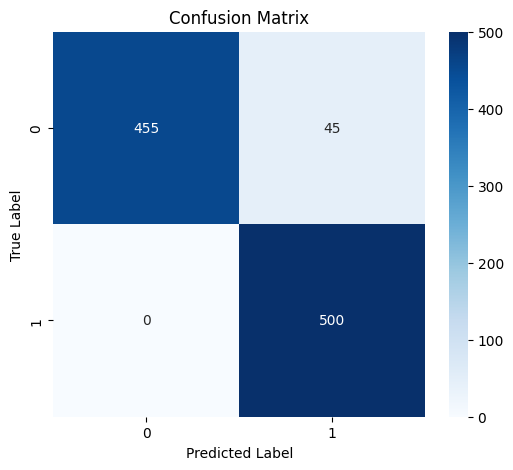

In [191]:
# Load Dataset & DataLoader
input_dim = dft.shape[1] - 1  # Number of features (excluding label)
episodic_dataset = EpisodicTabularDataset(dft, num_episodes=100, support_size=5, query_size=5)
train_loader = DataLoader(episodic_dataset, batch_size=1, shuffle=True)

# Initialize Model & Optimizer
model = ProtoNet(input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
train_protonet(model, train_loader, optimizer, epochs=100)

# Evaluate the model
evaluate_protonet(model, train_loader)

### Predicting on Test Data

In [192]:
with open('protonet_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [193]:
torch.save(model.state_dict(), "protonet.pth")

In [194]:
model = ProtoNet(input_dim)

In [195]:
model.load_state_dict(torch.load("protonet.pth"))
model.eval()

/var/folders/sl/kmcbrl6d3m72vgm_37_mw72w0000gn/T/ipykernel_20851/3481822368.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("protonet.pt

ProtoNet(
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=32, bias=True)
  )
)

In [196]:
prototypes = model.get_prototypes()

In [197]:
df_test = pd.DataFrame()

In [198]:
import torch
import pandas as pd
from torch.utils.data import DataLoader

def df_to_tensors(df):
    if 'OE_Quality_Flag' not in df.columns:
        X = torch.tensor(df.values, dtype=torch.float32)
        y = torch.tensor(pd.DataFrame({'a':123}).values, dtype=torch.long)
        return X
    X = torch.tensor(df.drop(columns=['OE_Quality_Flag']).values, dtype=torch.float32)
    y = torch.tensor(df['OE_Quality_Flag'].values, dtype=torch.long)
    return X, y

In [199]:
query_X, _ = df_to_tensors(test_df)

In [200]:
def predict_protonet_ordered(model, prototypes, query_X):
    model.eval()  # Set model to evaluation mode

    # Compute class prototypes from support set
    prototypes = prototypes

    # Compute class probabilities for the query set
    _, log_probs = compute_loss(prototypes, query_X, None, model)

    # Get predictions (keeping order)
    preds = log_probs.argmax(dim=1).cpu().numpy()

    return preds

In [201]:
# Get ordered predictions for test data
test_predictions = predict_protonet_ordered(model, prototypes, query_X)

# Add predictions to test DataFrame
test_df['OE_Quality_Flag'] = test_predictions

# Display predicted DataFrame
print(test_df.head())

           Q1.   Q6   Flavored/Mixed Beer   Non-Alcoholic Beers   Hard Ciders  \
1241 -0.378837  0.0              1.210433              2.405406      1.567408   
1889 -0.880528  0.0             -0.826151             -0.415730     -0.637996   
708  -0.713298  0.0              1.210433             -0.415730     -0.637996   
594   0.708160  0.0             -0.826151             -0.415730     -0.637996   
2129  1.126235  0.0             -0.826151             -0.415730     -0.637996   

       Hard Kombucha      Wine   Hard Beverage   Distilled Spirits       Q7.  \
1241        2.532849  0.879423        1.073963            0.734106  0.873604   
1889       -0.394812  0.879423       -0.931131            0.734106  0.873604   
708        -0.394812  0.879423        1.073963            0.734106  0.873604   
594        -0.394812 -1.137109       -0.931131            0.734106 -1.144684   
2129       -0.394812  0.879423       -0.931131            0.734106  0.873604   

      ...  Q14.bin0  Q14.bin1  Q